<a href="https://colab.research.google.com/github/neoyipeng2018/cnn/blob/master/WSE_0_3D_Open_Close_Volume_GAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reading Tea Leaves in the Charts
Not sure if technical analysis actually works, but if it does, a CNN should be able to read and get signals way faster and more consistently.

## Prerequisite

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash    

Updating fastai...
Done.


In [0]:
from google.colab import drive

In [0]:
%reload_ext autoreload
%autoreload 2
import os
from fastai.vision import *

## Feeding Time Series as Images into TL-CNN
I've done the offline cleaning of random 500 stocks' returns time series in HKEX and transforming them in a compiled image of Granular Angular Field, Recurrence Plots and Markov Transition Field.

We will focus on the importing and training of the classifier here.

### Loading data, prepring databunch

In [0]:
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd '/content/gdrive/My Drive/fastai/cnn'

/content/gdrive/My Drive/fastai/cnn


In [0]:
bs = 64 #batch size

In [0]:
path = Path(os.getcwd())

In [0]:
df = pd.read_csv('WSE_labels.csv')
df.head(2)

,name,label
0,2015_2016_WSE_4FUNME.png,0
1,2013_2014_WSE_ARCUS .png,0


In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai/cnn/.git'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/README.md'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/First_Try.ipynb'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/models'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/cnn_input'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/WSE_ALL_labels.csv'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/WSE_labels.csv'),
 PosixPath('/content/gdrive/My Drive/fastai/cnn/HKEX_labels.csv')]

In [0]:
#do flip = False - does not help; allowing flip
data = ImageDataBunch.from_csv(path,csv_labels='WSE_labels.csv',
                               folder='cnn_input',ds_tfms=get_transforms(do_flip = False), 
                               size=128, bs=bs, valid_pct=0.3).normalize(imagenet_stats)

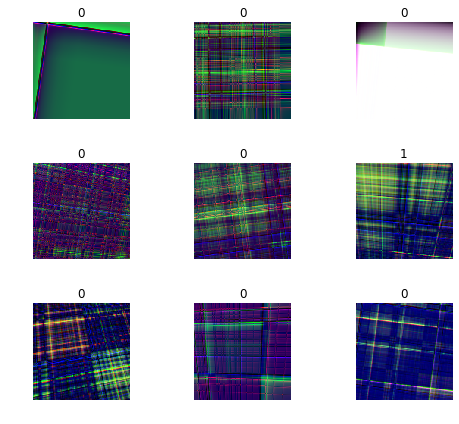

In [0]:
data.show_batch(rows=3, figsize=(7,6))

### Loading and training Resnet-50 in 2 Stages

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy,Recall(average='binary')]).mixup()
#learn = cnn_learner(data, models.resnet50, metrics=accuracy).mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 46767508.88it/s]


In [0]:
class AddCoords(nn.Module):

    def __init__(self, with_r=False):
        super().__init__()
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        xx_channel = xx_channel.float() / (x_dim - 1)
        yy_channel = yy_channel.float() / (y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)

        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel.type_as(input_tensor) - 0.5, 2) + torch.pow(yy_channel.type_as(input_tensor) - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret


class CoordConv(nn.Module):

    def __init__(self, in_channels, out_channels, with_r=False, **kwargs):
        super().__init__()
        self.addcoords = AddCoords(with_r=with_r)
        in_size = in_channels+2
        if with_r:
            in_size += 1
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)
        return ret

In [0]:
learn.layer_groups[0][0] = CoordConv(3,64,kernel_size=7,stride=2,padding=3)
learn.layer_groups[0][0]

CoordConv(
  (addcoords): AddCoords()
  (conv): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
)

In [0]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=5, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [0]:
learn.loss_fn = FocalLoss()

In [0]:
#learn.lr_find()

In [0]:
#learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,recall,time
0,0.962755,0.673897,0.689888,0.117647,05:41
1,0.722460,0.596074,0.786517,0.176471,04:27
2,0.608728,0.505461,0.746067,0.223529,04:32
3,0.551446,0.479252,0.788764,0.188235,04:26


In [0]:
learn.save('TL-CNN-1')

In [0]:
#learn.lr_find()

In [0]:
learn.unfreeze()

In [0]:
#learn.recorder.plot()

In [0]:
#learn.load('TL-CNN-1')

In [0]:
lr = 7e-3

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,lr/100))

epoch,train_loss,valid_loss,accuracy,recall,time
0,0.450969,0.456390,0.802247,0.141176,05:29
1,0.454154,0.416895,0.813483,0.141176,05:30
2,0.438533,0.407254,0.820225,0.141176,05:31
3,0.436114,0.394292,0.824719,0.188235,05:30


In [0]:
learn.save('TL-CNN-2')

In [0]:
#learn.load('TL-CNN-2')

### Results - we really care more about recall, i.e. being right when label predicted it 1


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

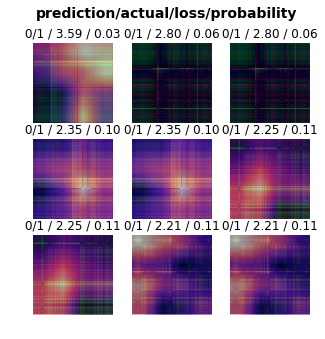

In [0]:
interp.plot_top_losses(9, figsize=(5,5))

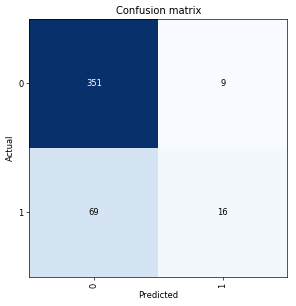

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [0]:
16/25

0.64